In [1]:
!nvidia-smi

Thu Feb 22 17:12:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.23       Driver Version: 442.23       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
!pip install gdown
!pip install tensorflow

  Using cached tensorflow-2.13.1-cp38-cp38-win_amd64.whl (1.9 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow) (from versions: 0.0.1, 2.10.0.dev20220728, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow-intel==2.13.1; platform_system == "Windows" (from tensorflow)


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [13]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

c:\users\lenovo\anaconda3\anaconda\lib\site-packages\gdown\__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: C:\Users\Lenovo\spx.csv

  0%|          | 0.00/152k [00:00<?, ?B/s]
100%|##########| 152k/152k [00:00<00:00, 1.32MB/s]
100%|##########| 152k/152k [00:00<00:00, 1.32MB/s]


In [15]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20932\2294837958.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


In [16]:

df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


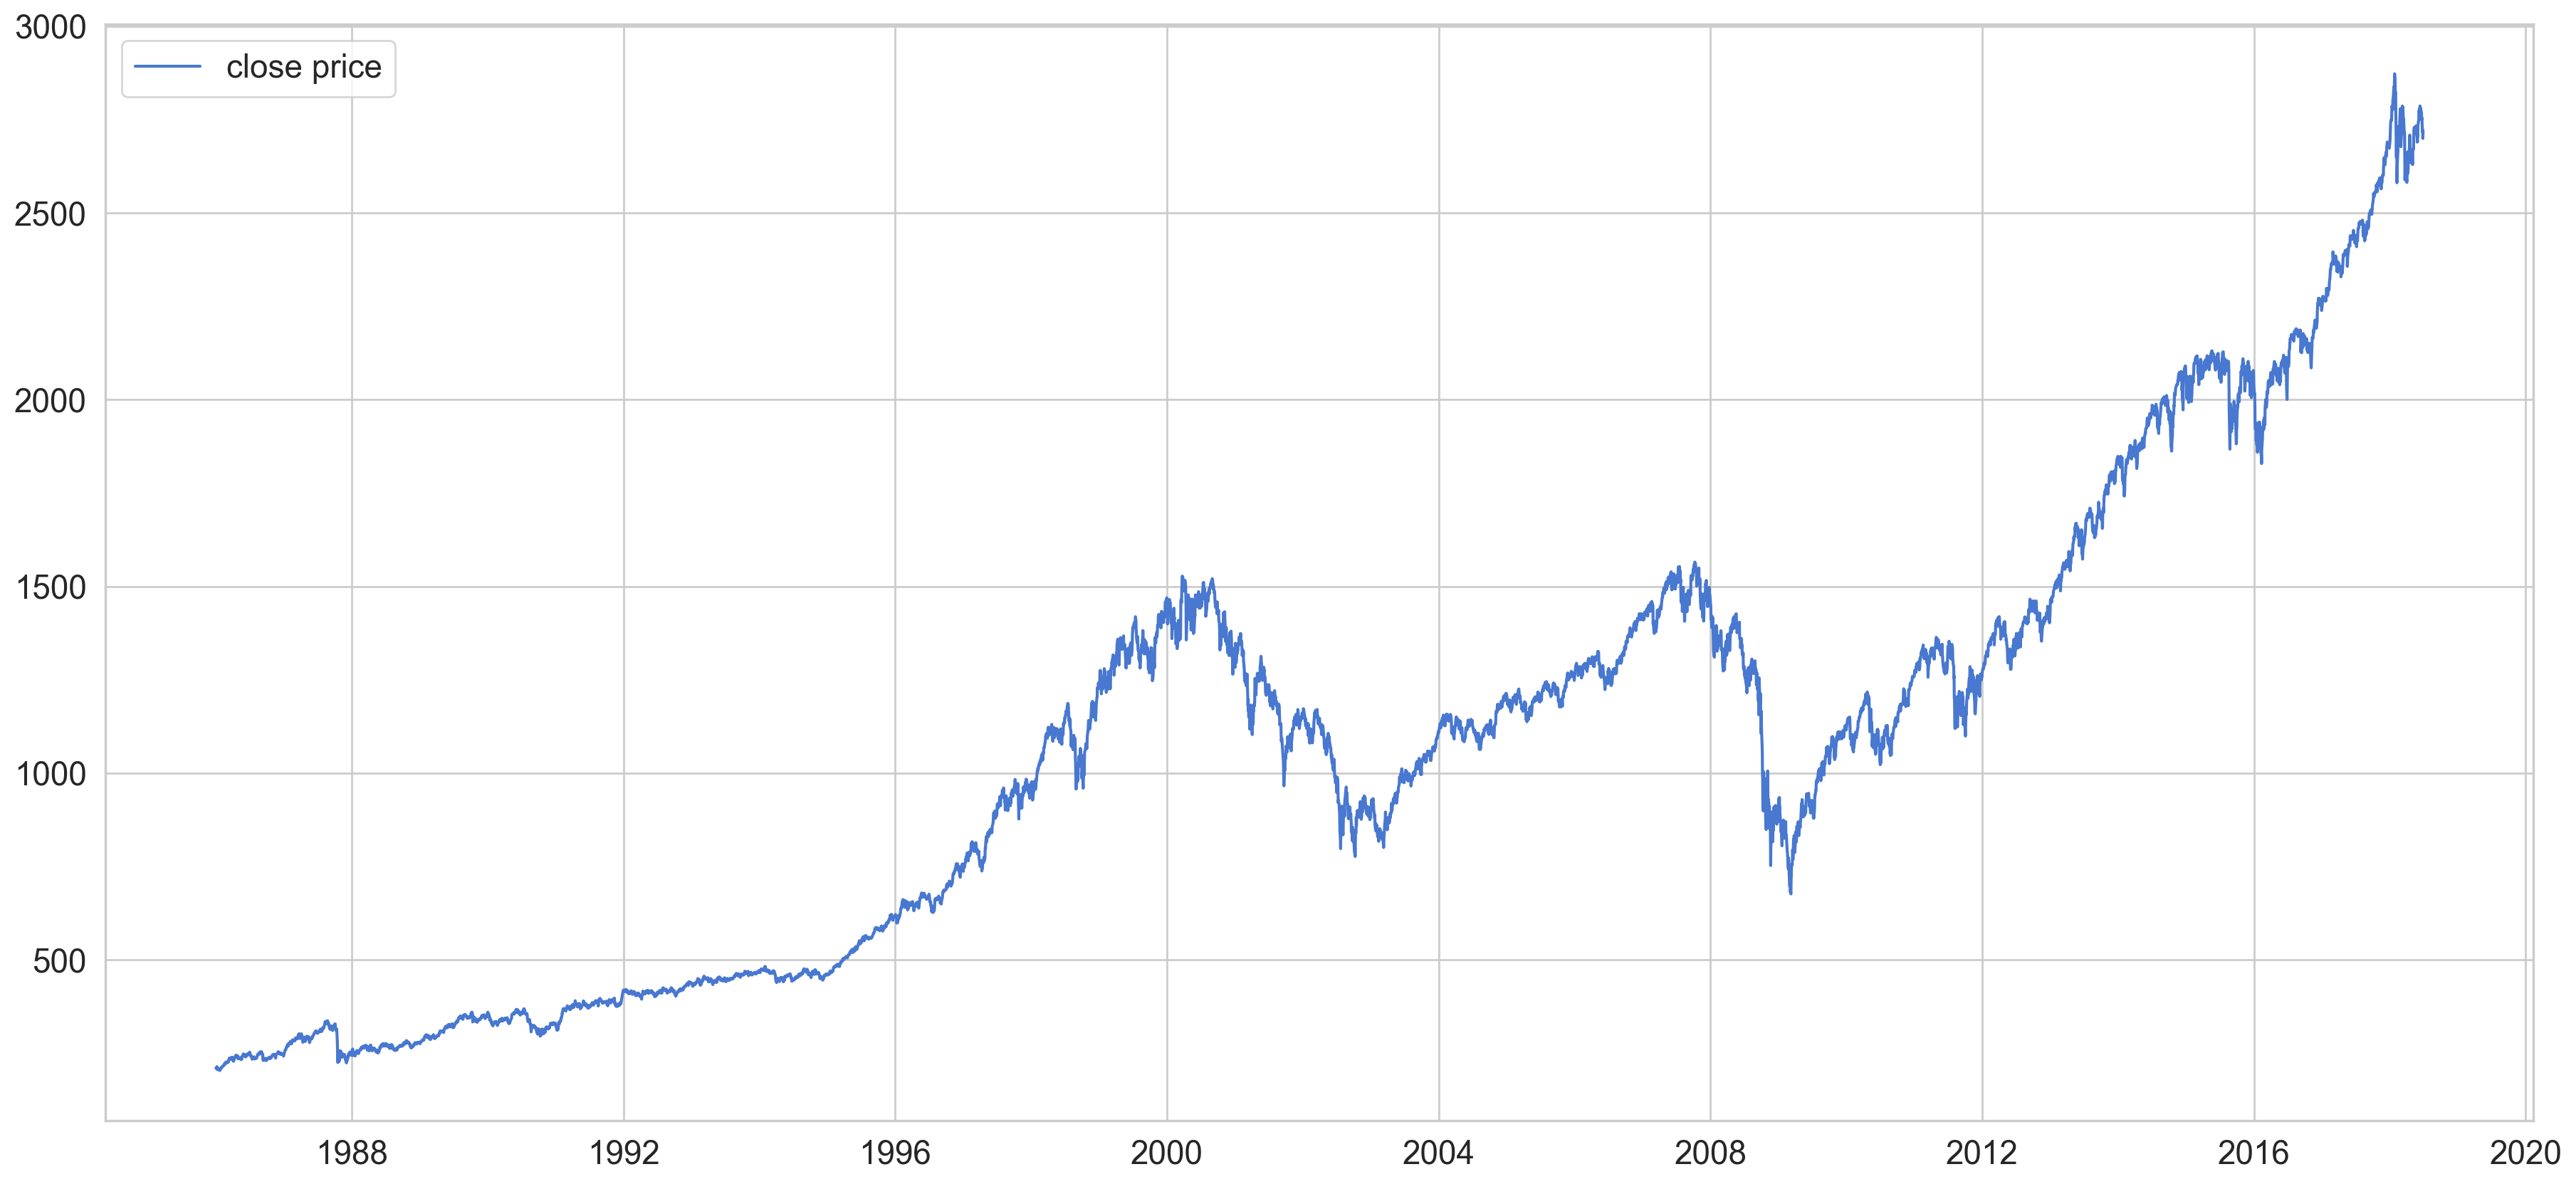

In [17]:
plt.plot(df, label='close price')
plt.legend();

In [18]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20932\1827044255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20932\1827044255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [23]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10

218/218 [==============================] - 14s 38ms/step - loss: 0.1695 - val_loss: 0.3207
Epoch 2/10
218/218 [==============================] - 8s 34ms/step - loss: 0.1033 - val_loss: 0.2650
Epoch 3/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1017 - val_loss: 0.3159
Epoch 4/10
218/218 [==============================] - 7s 32ms/step - loss: 0.1195 - val_loss: 0.3041
Epoch 5/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1276 - val_loss: 0.3082
Epoch 6/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1240 - val_loss: 0.2067
Epoch 7/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1165 - val_loss: 0.1681
Epoch 8/10
218/218 [==============================] - 7s 33ms/step - loss: 0.1204 - val_loss: 0.1557
Epoch 9/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1252 - val_loss: 0.1544
Epoch 10/10
218/218 [==============================] - 7s 34ms/step - loss: 0.1221 - val_

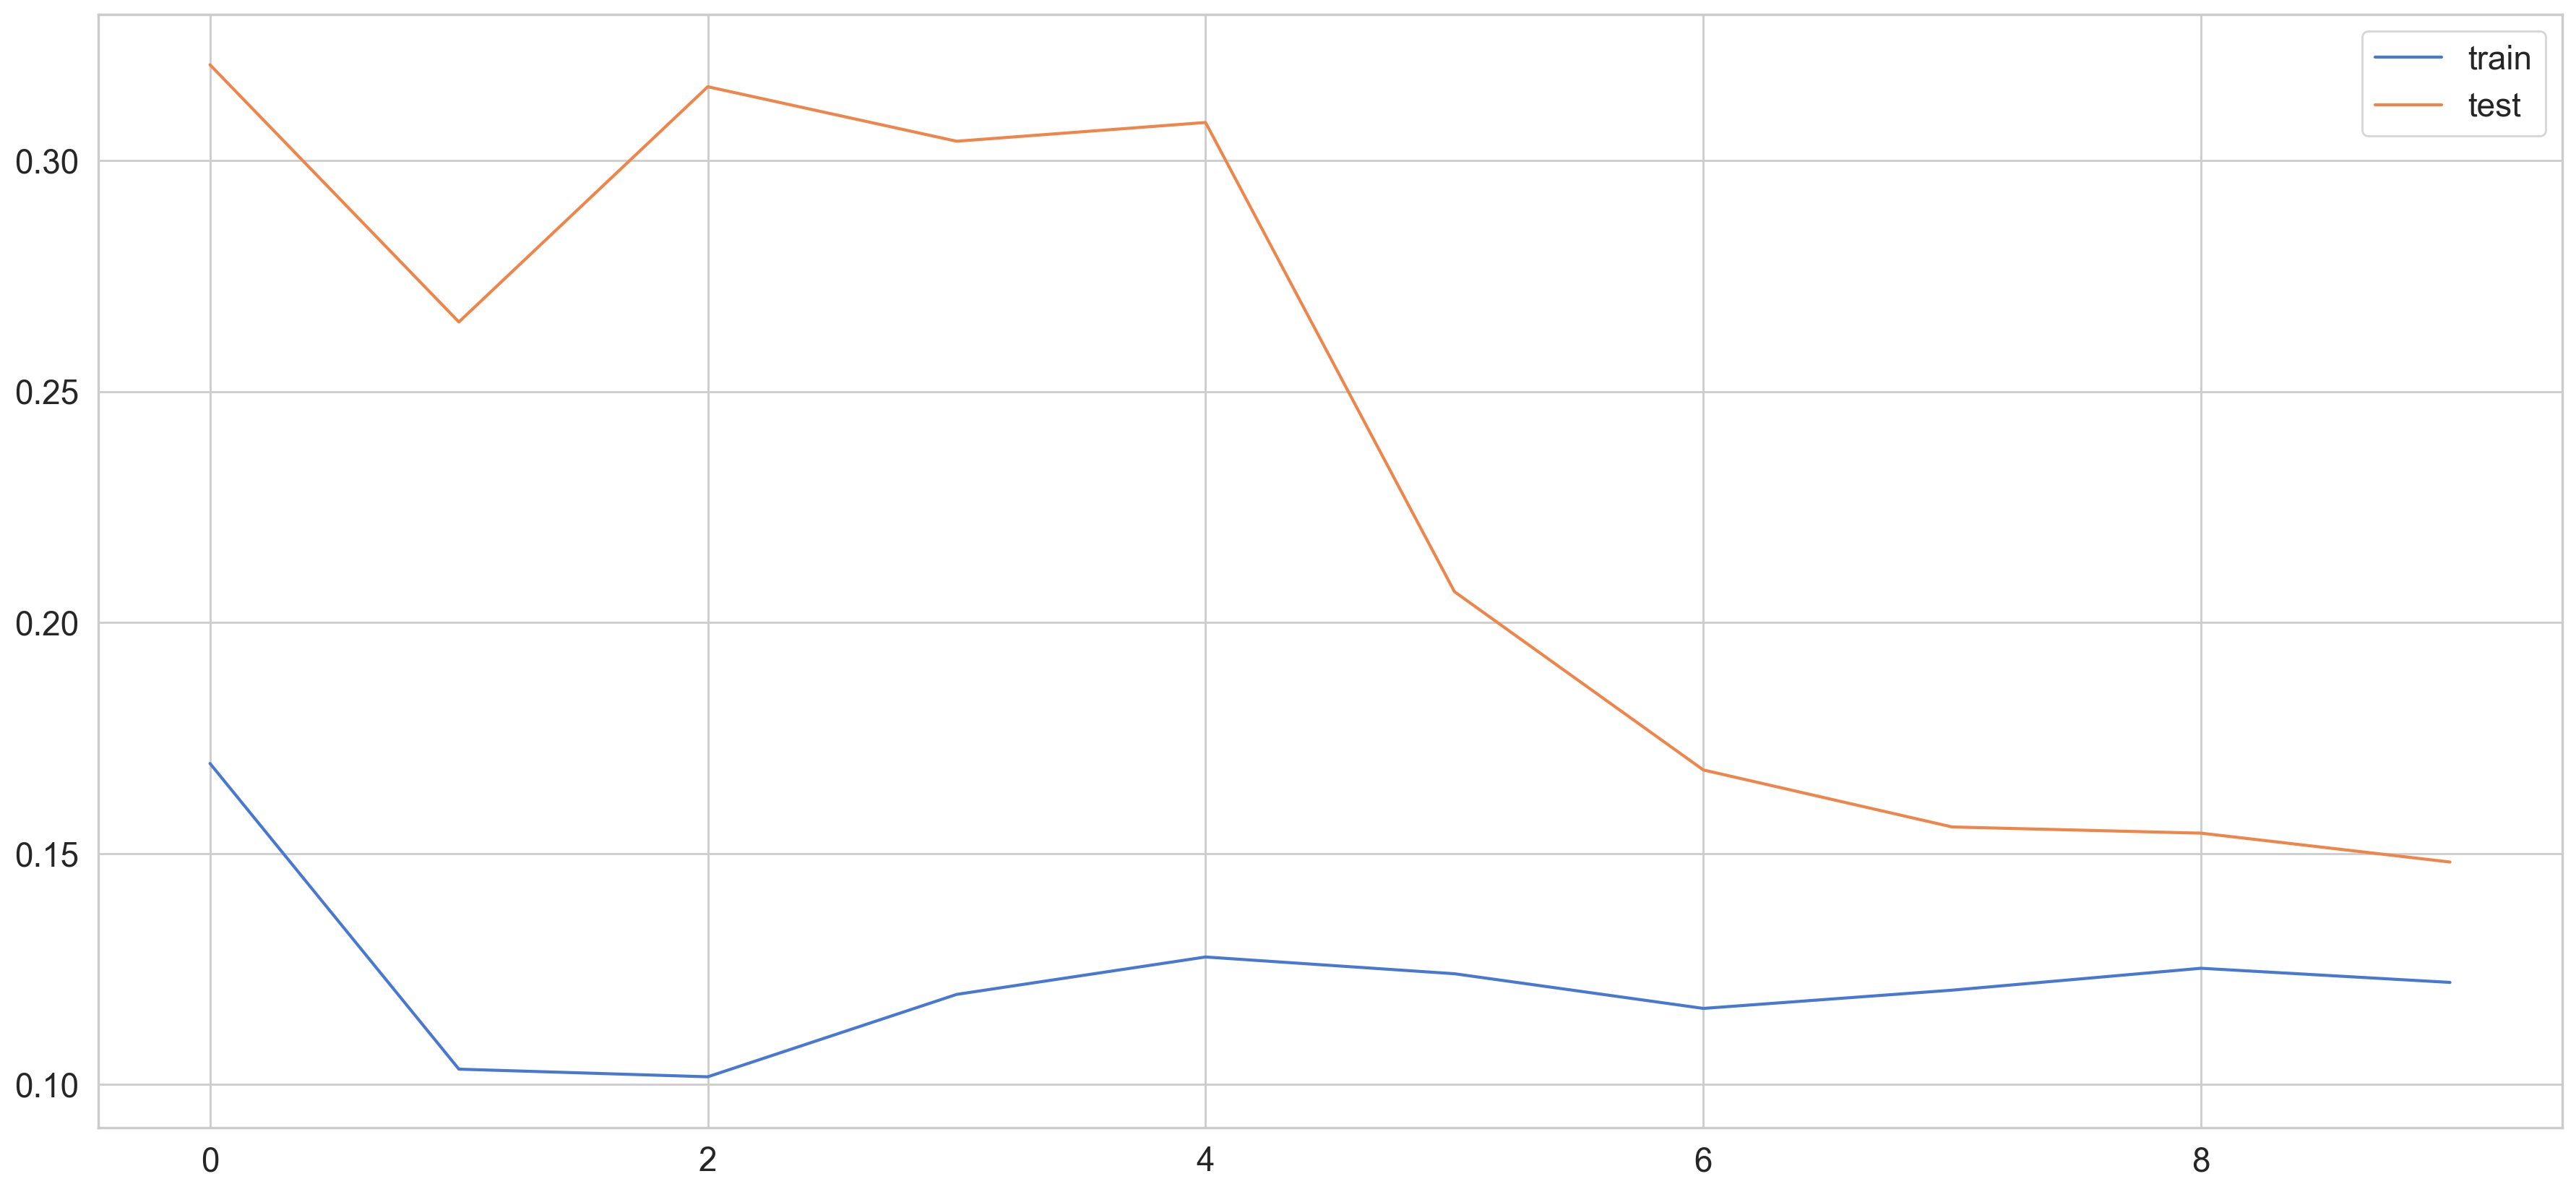

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [26]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
     

243/243 [==============================] - 5s 15ms/step


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20932\1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


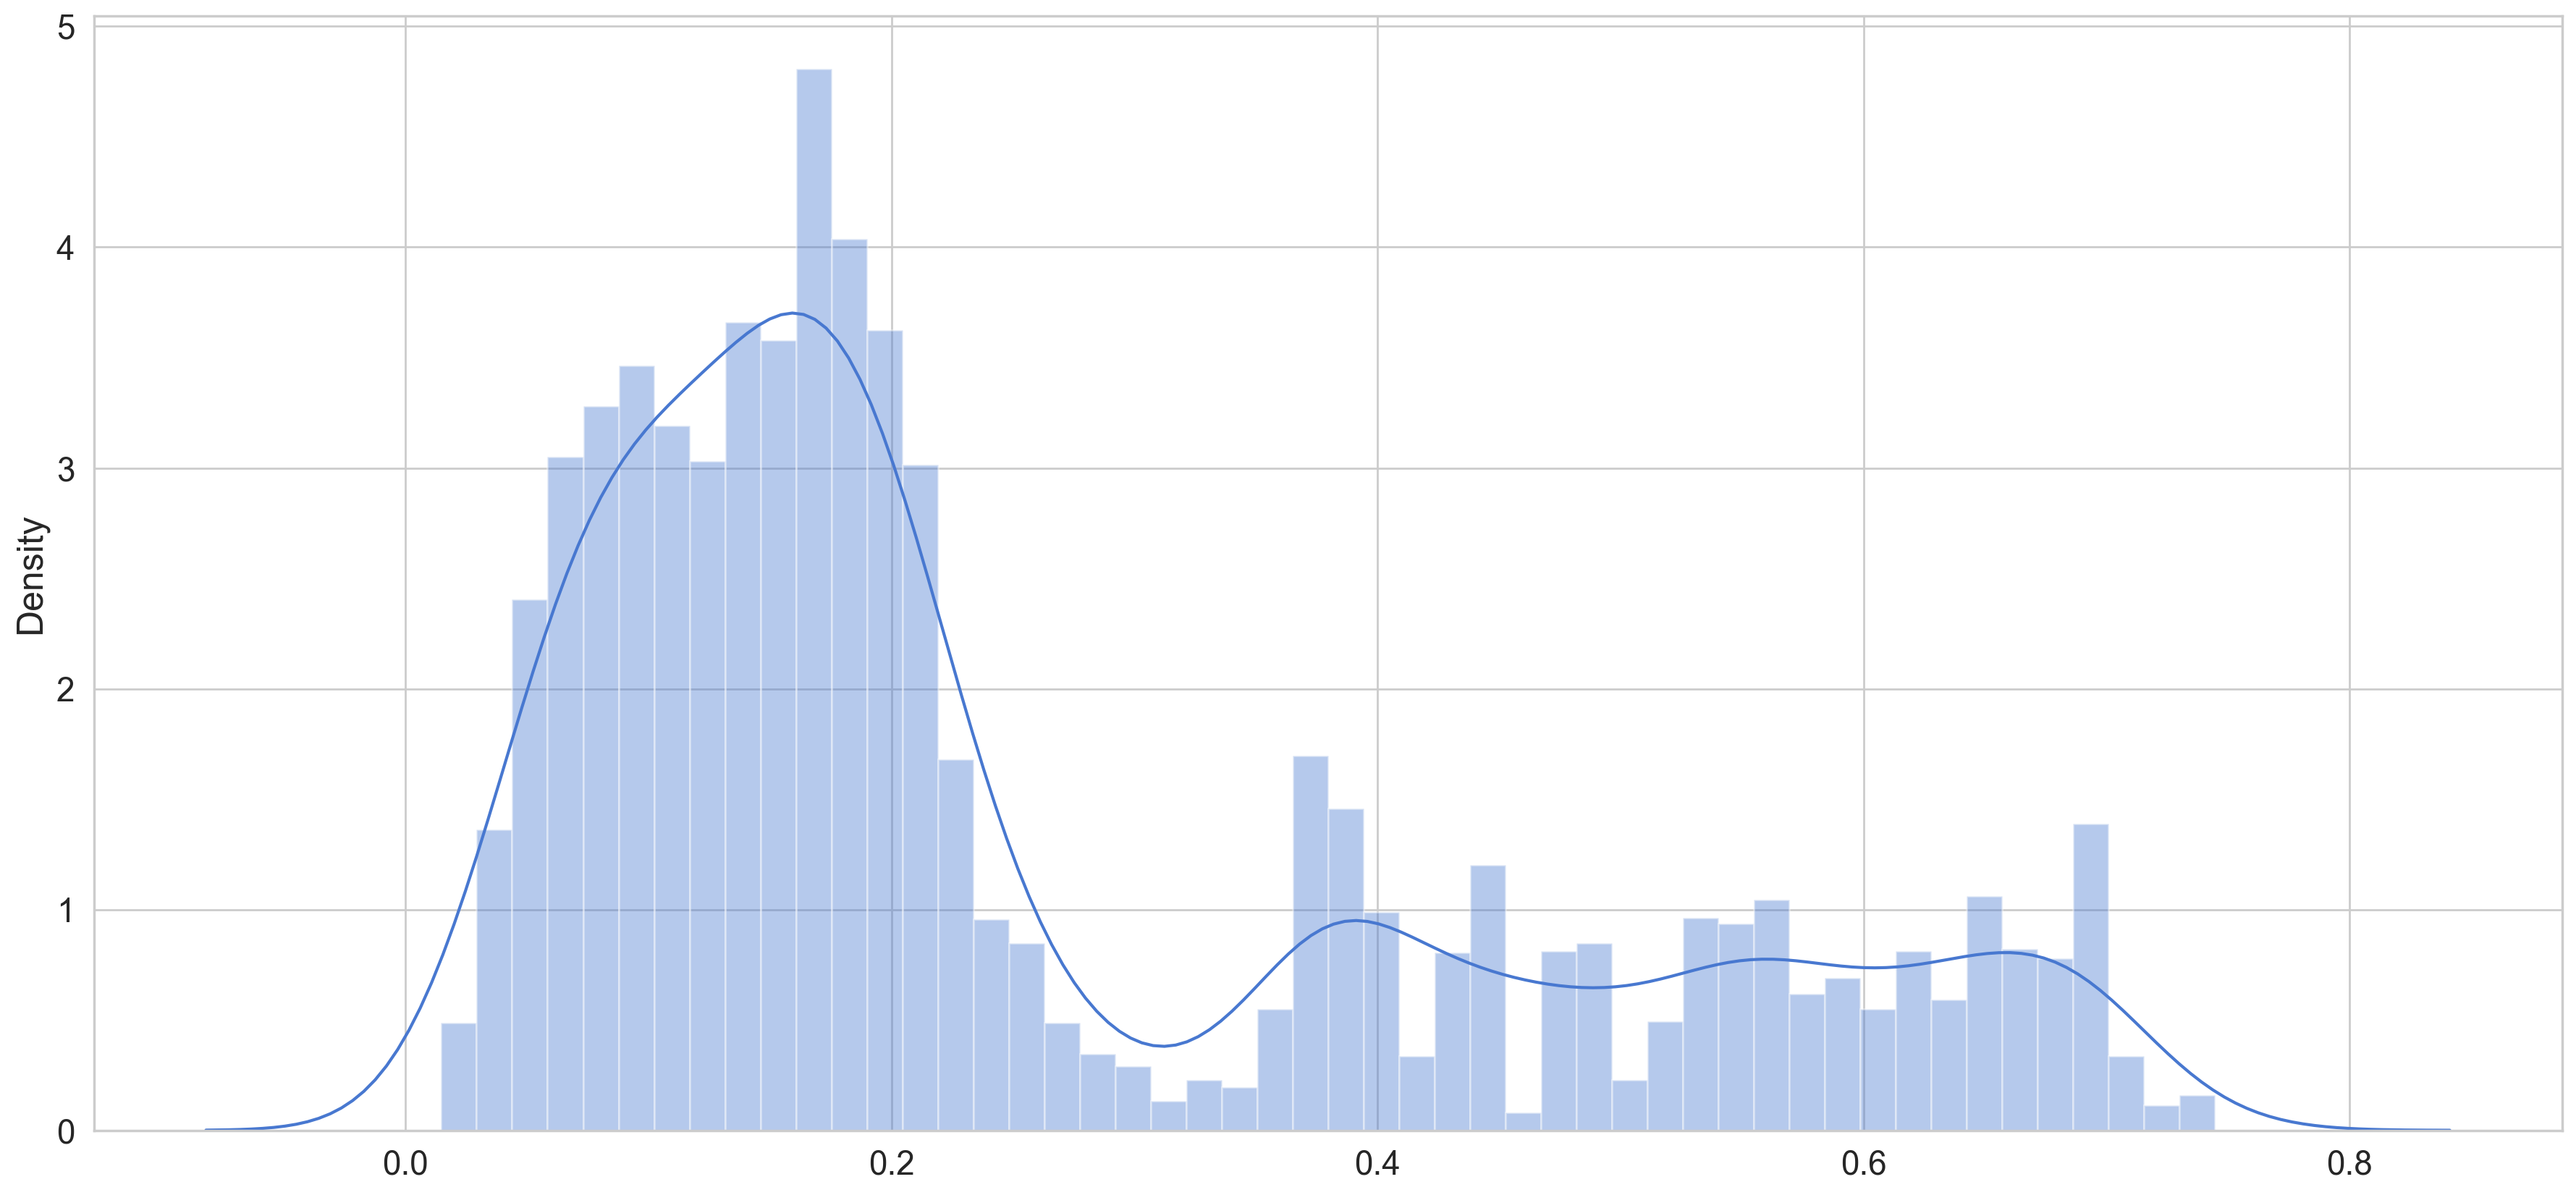

In [27]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [28]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 18ms/step


In [29]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

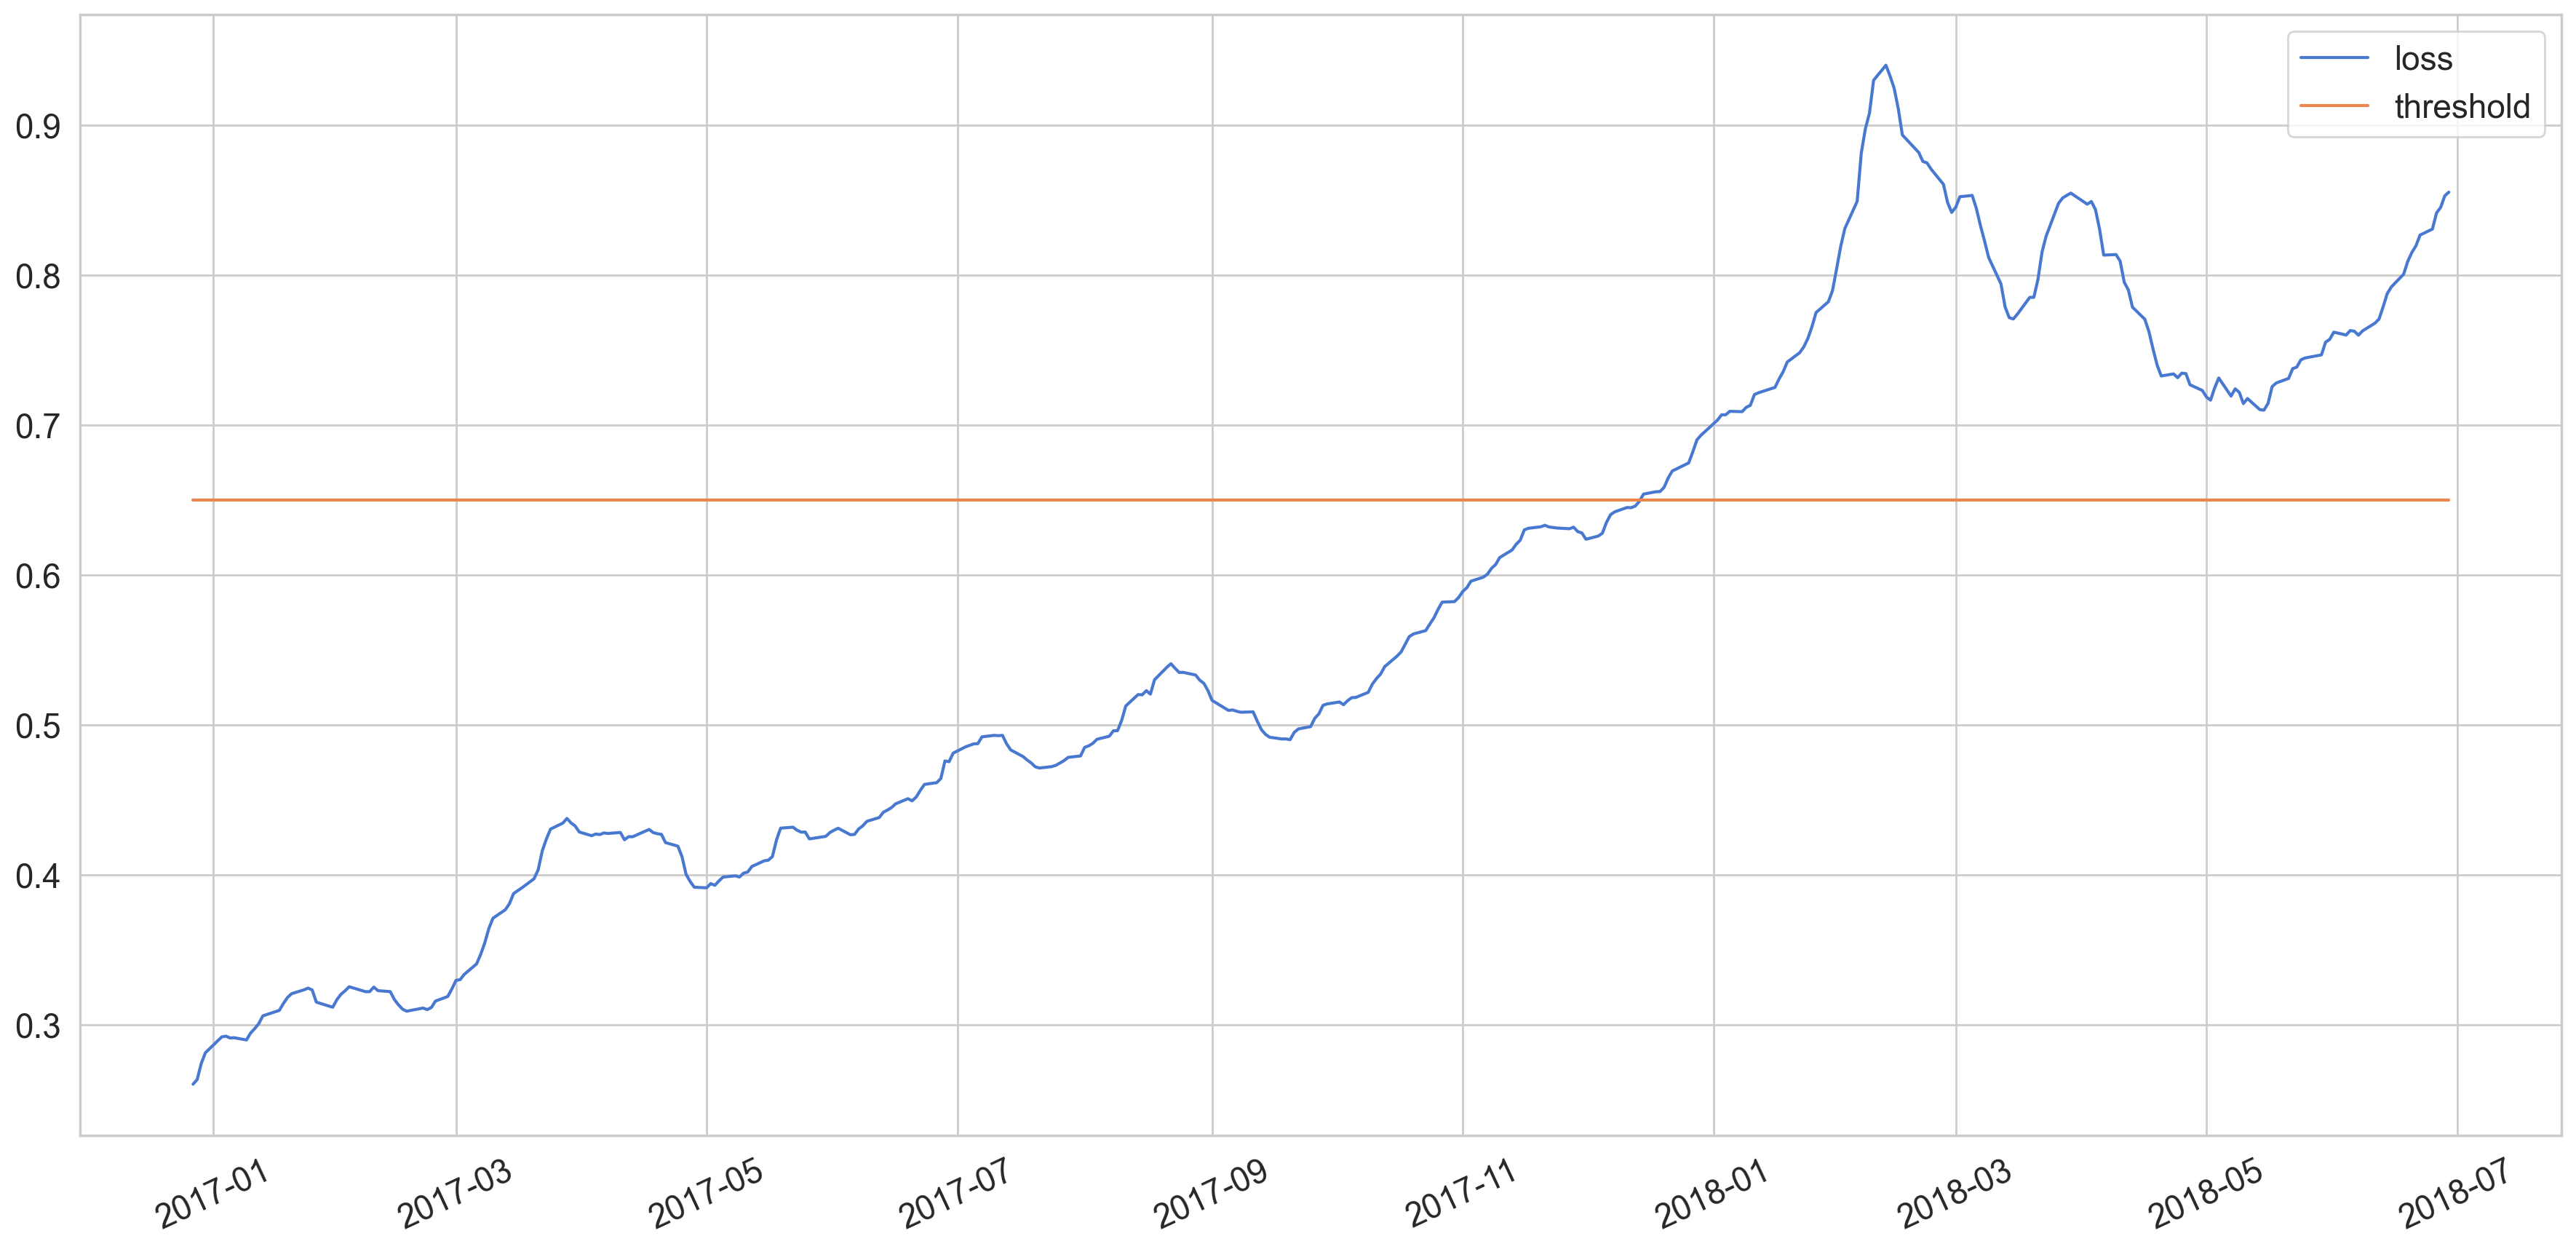

In [30]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [31]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-12-15,0.653897,0.65,True,3.157148
2017-12-18,0.655454,0.65,True,3.184102
2017-12-19,0.655574,0.65,True,3.167779
2017-12-20,0.658349,0.65,True,3.163610
2017-12-21,0.664573,0.65,True,3.173602


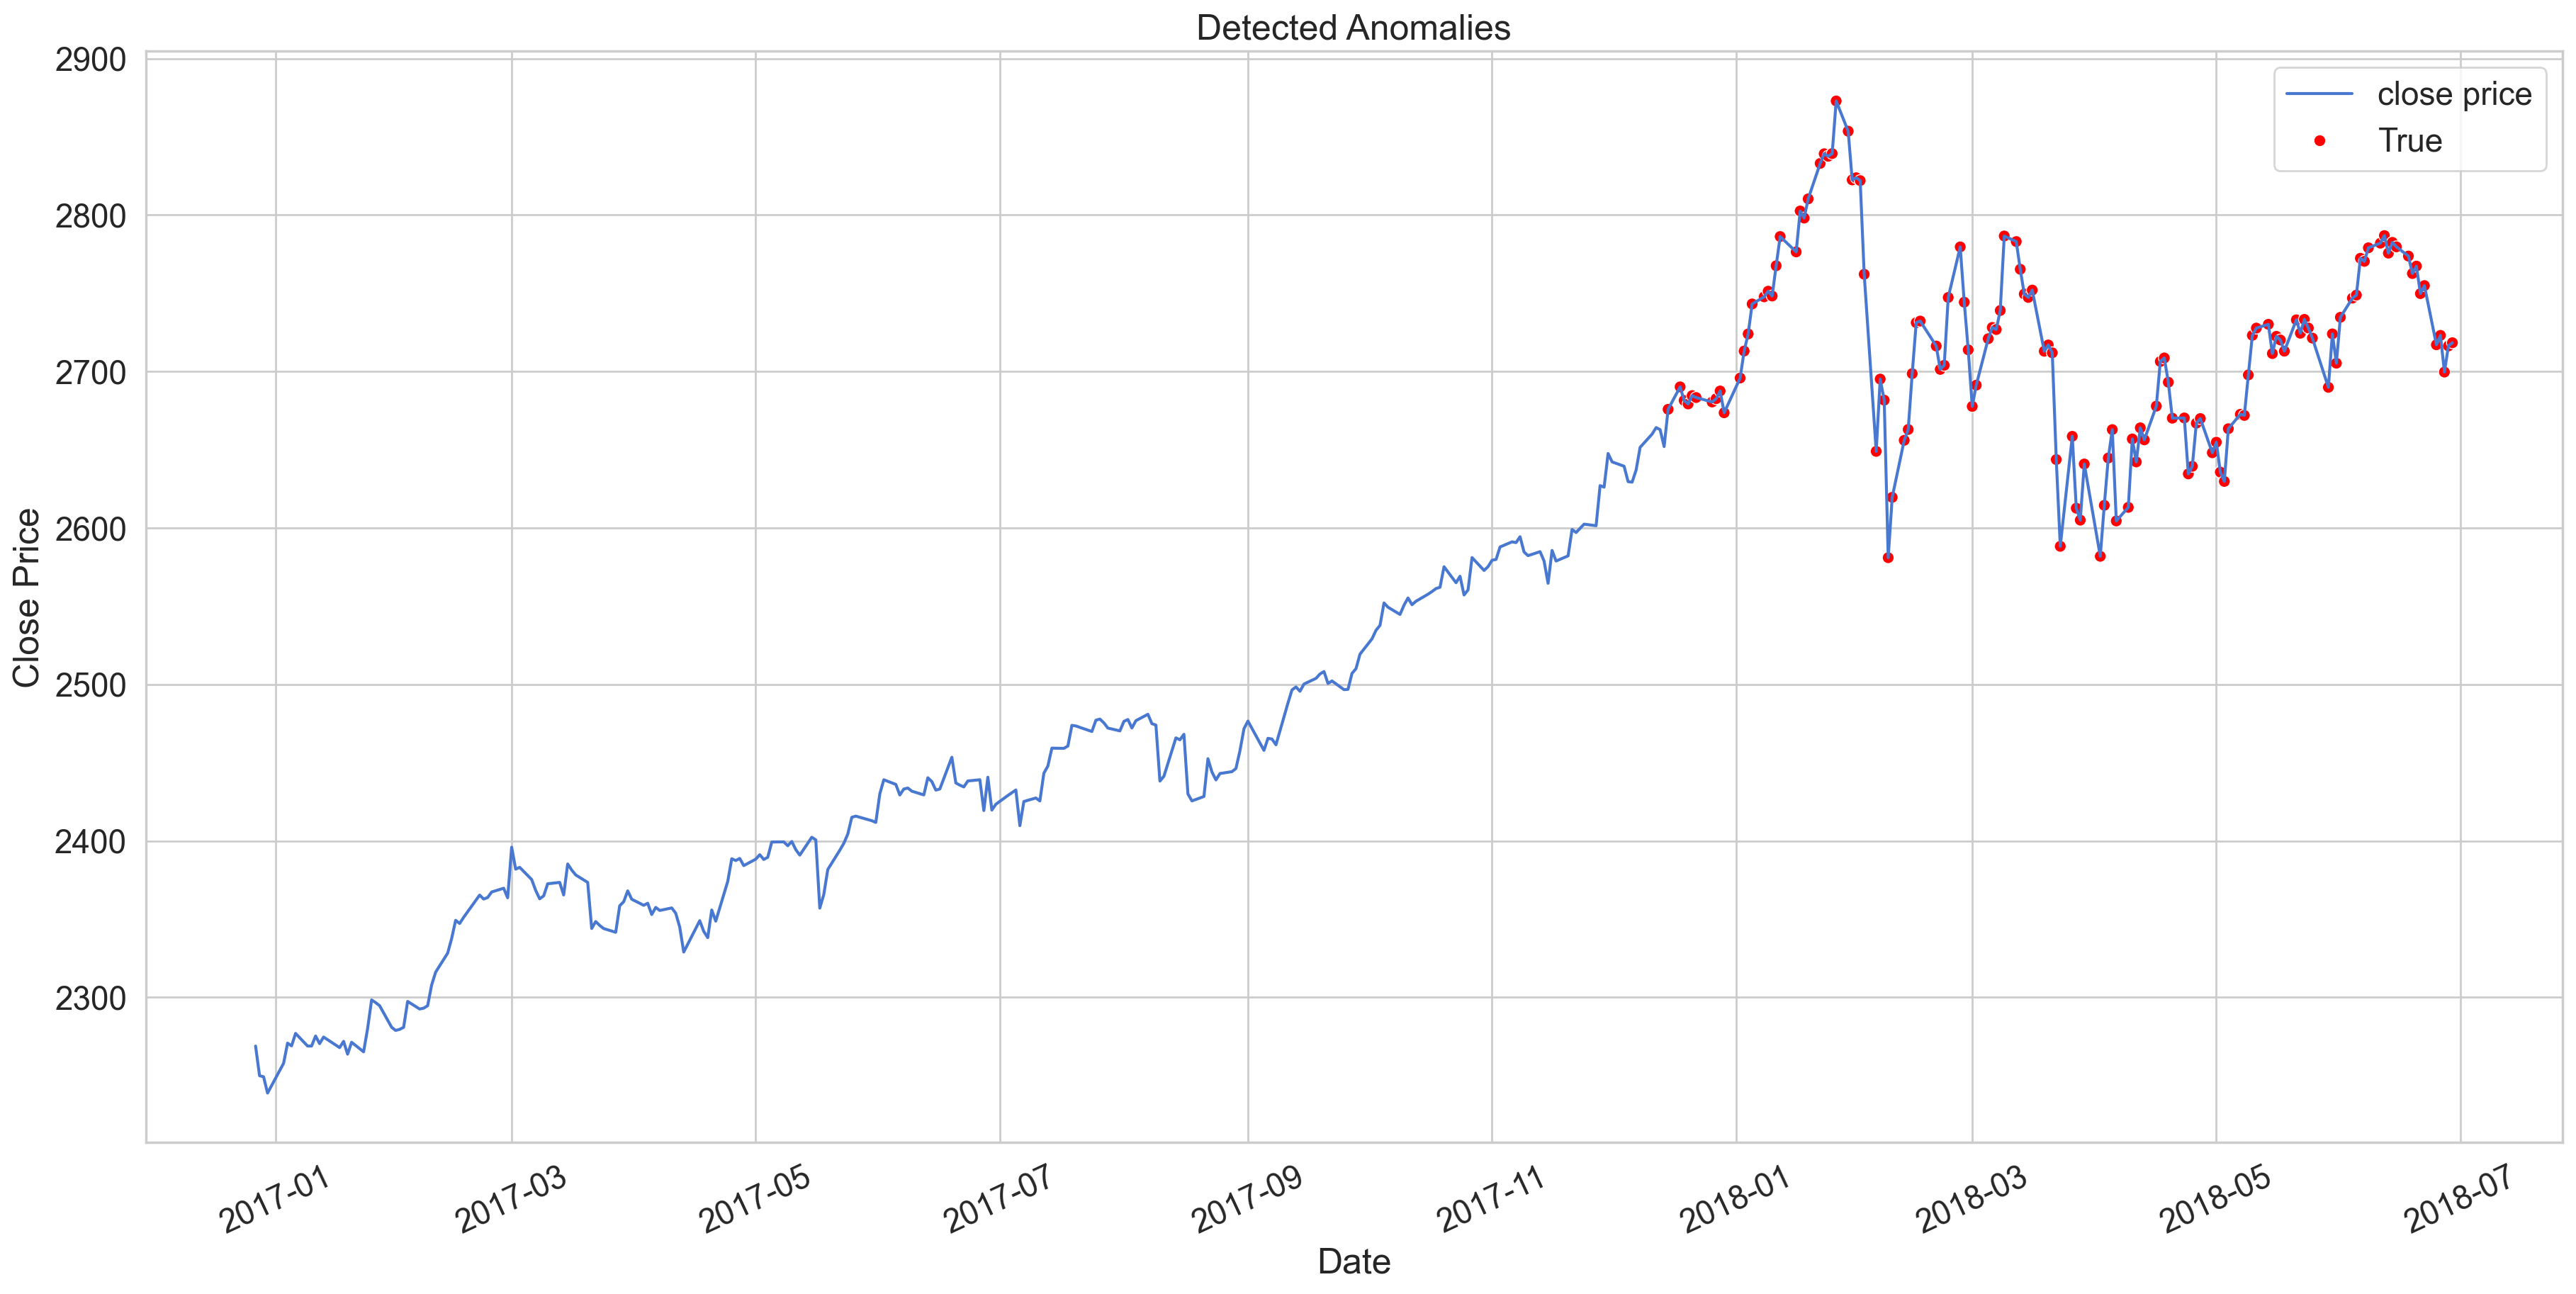

In [37]:
plt.plot(
    test[TIME_STEPS:].index, 
    scaler.inverse_transform(test[TIME_STEPS:][['close']]), 
    label='close price'
)

sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies[['close']]).squeeze(),  # Convert to 1D array
    hue=anomalies['anomaly'],  # Use the 'anomaly' column to set different colors
    palette={0: 'blue', 1: 'red'},  # Set colors for 0 (normal) and 1 (anomaly)
    legend='full',  # Show legend with color mapping
)

plt.xticks(rotation=25)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Detected Anomalies')
plt.legend()
plt.show()

